In [14]:
import sqlite3
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("Librerías importadas.")

Librerías importadas.


In [15]:
# --- Configuración ---
# Ruta a la base de datos que ya creaste
DB_PATH = Path("data/artifacts/database.db") # Ajustá esta ruta si es necesario

# Tabla que queremos explorar (la de datos crudos)
TABLE_NAME = "input_data"

# Carpeta donde se guardarán los gráficos y reportes
OUT_DIR = Path("artifacts/eda_sqlite")
# ---------------------

# Creamos la carpeta de salida
OUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Base de datos a leer: {DB_PATH}")
print(f"Directorio de salida: {OUT_DIR}")

Base de datos a leer: data\artifacts\database.db
Directorio de salida: artifacts\eda_sqlite


In [23]:
# -------------------- Utilidades de guardado --------------------
def save_csv(df: pd.DataFrame, path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(path, index=False)
    print(f"[OK] Guardado CSV: {path}")

def save_txt(text: str, path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)
    path.write_text(text, encoding="utf-8")
    print(f"[OK] Guardado TXT: {path}")

def safe_cols(df: pd.DataFrame, cols):
    """Devuelve solo las columnas que existan en el DataFrame."""
    return [c for c in cols if c in df.columns]

# -------------------- Gráficos (matplotlib puro) --------------------
def plot_hist(series: pd.Series, title: str, out_path: Path, bins=50, logx=False):
    data = series.dropna().to_numpy()
    if len(data) == 0:
        print(f"[WARN] {series.name}: no hay datos para histograma.")
        return
    plt.figure()
    if logx:
        data = data[data > 0]
        if len(data) == 0:
            print(f"[WARN] {series.name}: no hay datos > 0 para log10.")
            plt.close()
            return
        data = np.log10(data)
        plt.hist(data, bins=bins)
        plt.xlabel("log10(valor)")
    else:
        plt.hist(data, bins=bins)
        plt.xlabel(series.name)
    plt.ylabel("Frecuencia")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(out_path, dpi=120)
    plt.close()
    print(f"[OK] Gráfico: {out_path}")

def plot_scatter(x: pd.Series, y: pd.Series, title: str, out_path: Path, sample=5000):
    dx = x.copy()
    dy = y.copy()
    common_idx = dx.dropna().index.intersection(dy.dropna().index)
    if len(common_idx) == 0:
        print(f"[WARN] {x.name} vs {y.name}: no hay puntos comunes.")
        return
    if len(common_idx) > sample:
        common_idx = np.random.choice(common_idx, size=sample, replace=False)
    dx = dx.loc[common_idx]
    dy = dy.loc[common_idx]
    plt.figure()
    plt.scatter(dx, dy, s=5, alpha=0.5)
    plt.xlabel(x.name)
    plt.ylabel(y.name)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(out_path, dpi=120)
    plt.close()
    print(f"[OK] Gráfico: {out_path}")

def plot_bar(series: pd.Series, title: str, out_path: Path, top=15):
    s = series.dropna().sort_values(ascending=False).head(top)
    if s.empty:
        print(f"[WARN] Serie vacía para barras: {title}")
        return
    plt.figure()
    s.plot(kind="bar")
    plt.title(title)
    plt.ylabel("Valor")
    plt.xticks(rotation=20, ha="right")
    plt.tight_layout()
    plt.savefig(out_path, dpi=120)
    plt.close()
    print(f"[OK] Gráfico: {out_path}")

def plot_box_by_category(df: pd.DataFrame, value_col: str, cat_col: str,
                         title: str, out_path: Path, top=8):
    if cat_col not in df.columns or value_col not in df.columns:
        print(f"[WARN] Faltan columnas para boxplot {value_col} por {cat_col}")
        return
    tops = df[cat_col].value_counts().head(top).index.tolist()
    if len(tops) == 0:
        print(f"[WARN] Sin categorías para boxplot en {cat_col}")
        return
    data = [df.loc[df[cat_col] == t, value_col].dropna().to_numpy() for t in tops]
    if all(len(arr) == 0 for arr in data):
        print(f"[WARN] Sin datos numéricos para boxplot {value_col} por {cat_col}")
        return
    plt.figure()
    plt.boxplot(data, labels=tops, showfliers=False)
    plt.title(title)
    plt.ylabel(value_col)
    plt.xticks(rotation=20, ha="right")
    plt.tight_layout()
    plt.savefig(out_path, dpi=120)
    plt.close()
    print(f"[OK] Gráfico: {out_path}")

def plot_corr_heatmap(df_num: pd.DataFrame, title: str, out_path: Path):
    """Genera un mapa de calor de correlaciones numéricas."""
    if df_num.shape[1] < 2:
        print("[WARN] Correlación: se necesitan >= 2 columnas numéricas.")
        return
    plt.figure()
    
    # --- CORRECCIÓN ---
    # Se quitó numeric_only=True para compatibilidad con pandas < 2.0
    corr = df_num.corr()
    # --------------------
    
    im = plt.imshow(corr.values, aspect="auto")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(out_path, dpi=120)
    plt.close()
    print(f"[OK] Gráfico: {out_path}")

print("Funciones auxiliares definidas (versión corregida).")


Funciones auxiliares definidas (versión corregida).


In [24]:
if not DB_PATH.exists():
    print(f"Error: No se encontró la base de datos: {DB_PATH.resolve()}")
else:
    print(f"Conectando a SQLite: {DB_PATH}")
    conn = sqlite3.connect(str(DB_PATH))
    try:
        df = pd.read_sql_query(f"SELECT * FROM {TABLE_NAME};", conn)
        print("¡Datos cargados exitosamente desde la base de datos!")
        print(f"Filas: {len(df)}, Columnas: {len(df.columns)}")
    finally:
        conn.close()

# Mostrar un vistazo de los datos cargados
if 'df' in locals():
    display(df.head())

Conectando a SQLite: data\artifacts\database.db


¡Datos cargados exitosamente desde la base de datos!
Filas: 992192, Columnas: 12


,row_idx,rooms,bedrooms,bathrooms,surface_total,surface_covered,lat,lon,l2,l3,property_type,price
0,0,3.0,2.0,2.0,NaN,NaN,-58.442399,-34.573623,Capital Federal,Colegiales,Departamento,259000.0
1,1,3.0,2.0,2.0,77.0,67.0,-58.430493,-34.606620,Capital Federal,Almagro,Departamento,235500.0
2,2,2.0,NaN,1.0,60.0,55.0,-58.491760,-34.574123,Capital Federal,Villa Urquiza,Departamento,175000.0
3,3,2.0,1.0,1.0,74.0,47.0,-58.420737,-34.631770,Capital Federal,Boedo,PH,140000.0
4,4,3.0,2.0,1.0,66.0,64.0,-58.429983,-34.607225,Capital Federal,Almagro,Departamento,173000.0


In [25]:
if 'df' in locals():
    # 1.1) Shape
    save_txt(f"shape = {df.shape}", OUT_DIR / "01_shape.txt")

    # 1.2) Dtypes
    dtypes = df.dtypes.reset_index()
    dtypes.columns = ["column", "dtype"]
    save_csv(dtypes, OUT_DIR / "02_dtypes.csv")
    display(dtypes)

    # 1.3) Nulos
    nulls = df.isna().sum().reset_index()
    nulls.columns = ["column", "n_nulls"]
    nulls["pct_nulls"] = (nulls["n_nulls"] / max(len(df), 1) * 100).round(2)
    save_csv(nulls, OUT_DIR / "03_nulls.csv")
    display(nulls.sort_values(by="n_nulls", ascending=False))

    # 1.4) Describe Numérico
    desc = df.describe(include=[np.number]).T.reset_index()
    desc.rename(columns={"index": "column"}, inplace=True)
    save_csv(desc, OUT_DIR / "04_describe_numeric.csv")
    display(desc)

    # 1.5) Top Categorías
    cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
    if cat_cols:
        top_list = []
        for c in cat_cols:
            vc = df[c].value_counts(dropna=False).head(20).reset_index()
            vc.columns = [c, "count"]
            vc.insert(0, "column", c)
            top_list.append(vc)
        top_df = pd.concat(top_list, ignore_index=True)
        save_csv(top_df, OUT_DIR / "05_top_categories.csv")
        print("Reporte de categorías guardado.")
    else:
        print("No se encontraron columnas categóricas.")
else:
    print("El DataFrame 'df' no está cargado.")

[OK] Guardado TXT: artifacts\eda_sqlite\01_shape.txt
[OK] Guardado CSV: artifacts\eda_sqlite\02_dtypes.csv


,column,dtype
0,row_idx,int64
1,rooms,float64
2,bedrooms,float64
3,bathrooms,float64
4,surface_total,float64
5,surface_covered,float64
6,lat,float64
7,lon,float64
8,l2,object
9,l3,object


[OK] Guardado CSV: artifacts\eda_sqlite\03_nulls.csv


,column,n_nulls,pct_nulls
2,bedrooms,601493,60.62
5,surface_covered,555231,55.96
4,surface_total,544028,54.83
1,rooms,489147,49.30
3,bathrooms,219171,22.09
6,lat,153198,15.44
7,lon,152263,15.35
9,l3,57455,5.79
11,price,44381,4.47
0,row_idx,0,0.00


[OK] Guardado CSV: artifacts\eda_sqlite\04_describe_numeric.csv


,column,count,mean,std,min,25%,50%,75%,max
0,row_idx,992192.0,496095.500000,286421.303481,0.0,248047.750000,496095.500000,744143.250000,9.921910e+05
1,rooms,503045.0,2.858577,1.682454,1.0,2.000000,3.000000,4.000000,4.000000e+01
2,bedrooms,390699.0,2.086094,2.705342,-13.0,1.000000,2.000000,3.000000,9.000000e+02
3,bathrooms,773021.0,1.697637,1.072722,1.0,1.000000,1.000000,2.000000,2.000000e+01
4,surface_total,448164.0,493.511360,4101.381790,-200.0,50.000000,95.000000,270.000000,2.000000e+05
5,surface_covered,436961.0,576.953341,73839.980806,-170.0,45.000000,75.000000,155.000000,2.700000e+07
6,lat,838994.0,-169.138016,2564.392584,-71634.0,-58.760251,-58.444745,-58.064983,-3.504503e+01
7,lon,839929.0,-88.407573,1354.168489,-40768.0,-34.922562,-34.610802,-34.461145,8.505113e+01
8,price,947811.0,163172.956845,411869.394145,0.0,5000.000000,85000.000000,180000.000000,4.600000e+07


[OK] Guardado CSV: artifacts\eda_sqlite\05_top_categories.csv
Reporte de categorías guardado.


[OK] Gráfico: artifacts\eda_sqlite\A1_hist_price.png
[OK] Gráfico: artifacts\eda_sqlite\A2_hist_price_log.png


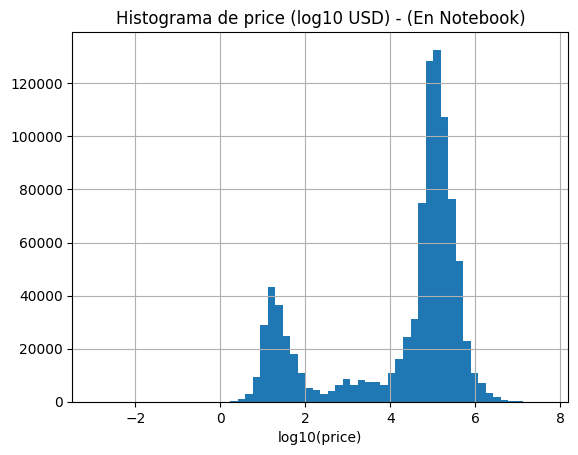

In [26]:
if 'df' in locals():
    if "price" in df.columns:
        # Histograma normal
        plot_hist(df["price"], "Histograma de price (USD)",
                  OUT_DIR / "A1_hist_price.png", bins=60, logx=False)
        
        # Histograma logarítmico
        plot_hist(df["price"], "Histograma de price (log10 USD)",
                  OUT_DIR / "A2_hist_price_log.png", bins=60, logx=True)
        
        # Mostramos uno en el notebook (opcional)
        plt.figure()
        df[df["price"] > 0]["price"].apply(np.log10).hist(bins=60)
        plt.title("Histograma de price (log10 USD) - (En Notebook)")
        plt.xlabel("log10(price)")
        plt.show()
    else:
        print("No se encontró la columna 'price'.")
else:
    print("El DataFrame 'df' no está cargado.")

[OK] Guardado CSV: artifacts\eda_sqlite\B1_avg_price_by_property_type.csv
[OK] Gráfico: artifacts\eda_sqlite\B1_avg_price_by_property_type.png


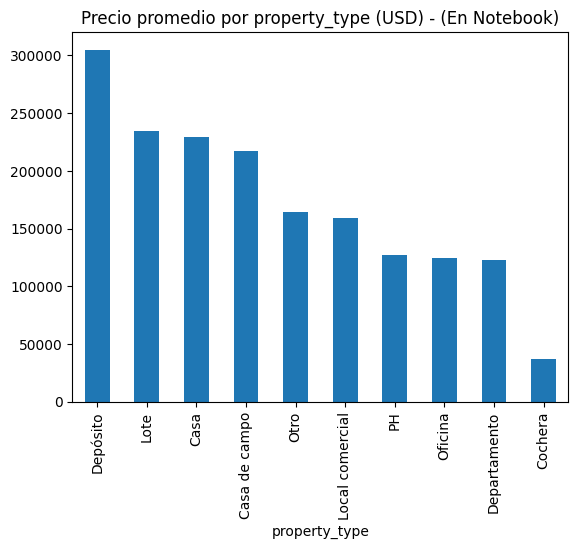

[OK] Gráfico: artifacts\eda_sqlite\B2_box_price_by_property_type.png


In [27]:
if 'df' in locals():
    # Barras: precio promedio por property_type
    if "property_type" in df.columns and "price" in df.columns:
        avg_price_by_pt = df.groupby("property_type")["price"].mean().sort_values(ascending=False).round(2)
        save_csv(avg_price_by_pt.reset_index().rename(columns={"price": "avg_price_usd"}),
                 OUT_DIR / "B1_avg_price_by_property_type.csv")
        plot_bar(avg_price_by_pt, "Precio promedio por property_type (USD)",
                 OUT_DIR / "B1_avg_price_by_property_type.png", top=15)
        
        # Mostramos en notebook
        avg_price_by_pt.head(15).plot(kind="bar", title="Precio promedio por property_type (USD) - (En Notebook)")
        plt.show()

    # Boxplot: price por property_type
    if "property_type" in df.columns and "price" in df.columns:
        plot_box_by_category(df, "price", "property_type",
                             "Distribución de price por property_type",
                             OUT_DIR / "B2_box_price_by_property_type.png", top=8)
else:
    print("El DataFrame 'df' no está cargado.")

In [28]:
if 'df' in locals():
    if "surface_total" in df.columns and "price" in df.columns:
        plot_scatter(df["surface_total"], df["price"],
                     "surface_total vs price",
                     OUT_DIR / "C1_scatter_surface_total_price.png",
                     sample=8000)
        
        # Mostramos en notebook (con menos 'sample' para que sea rápido)
        plot_scatter(df["surface_total"], df["price"],
                     "surface_total vs price (Muestra Notebook)",
                     OUT_DIR / "temp_scatter.png",
                     sample=2000)
        display(plt.imread(OUT_DIR / "temp_scatter.png"))
        
    else:
        print("Faltan 'surface_total' o 'price'.")
else:
    print("El DataFrame 'df' no está cargado.")

[OK] Gráfico: artifacts\eda_sqlite\C1_scatter_surface_total_price.png
[OK] Gráfico: artifacts\eda_sqlite\temp_scatter.png


array([[[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       ...,

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1.

[OK] Gráfico: artifacts\eda_sqlite\D1_corr_heatmap.png


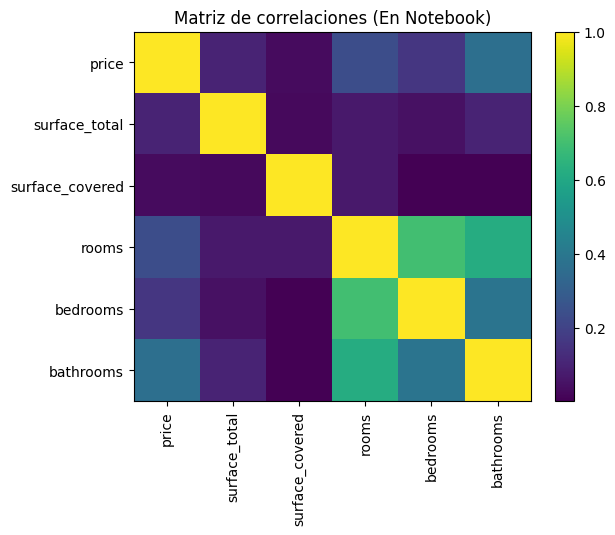

In [29]:
if 'df' in locals():
    num_candidates = ["price", "surface_total", "surface_covered", "rooms", "bedrooms", "bathrooms"]
    num_cols_present = safe_cols(df, num_candidates)

    if num_cols_present:
        plot_corr_heatmap(df[num_cols_present],
                          "Matriz de correlaciones (numéricas)",
                          OUT_DIR / "D1_corr_heatmap.png")
        
        # Mostramos en notebook
        corr = df[num_cols_present].corr()  # ✅ CORRECCIÓN

        plt.figure()
        plt.imshow(corr.values, aspect="auto")
        plt.colorbar()
        plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
        plt.yticks(range(len(corr.columns)), corr.columns)
        plt.title("Matriz de correlaciones (En Notebook)")
        plt.show()
    else:
        print("No hay columnas numéricas suficientes.")
else:
    print("El DataFrame 'df' no está cargado.")


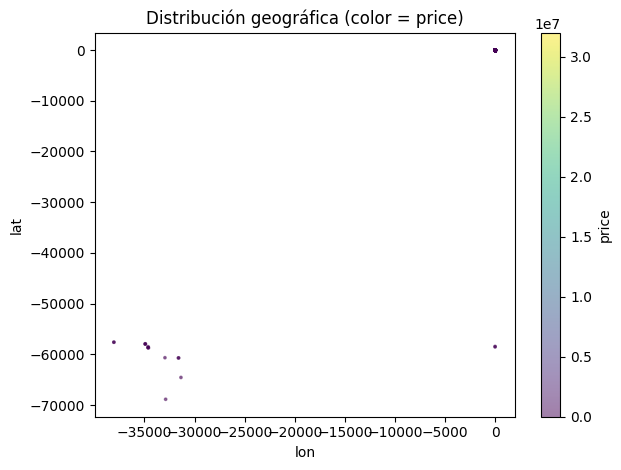

In [30]:
if 'df' in locals():
    if all(c in df.columns for c in ["lat", "lon", "price"]):
        # Hacemos una muestra para el notebook
        idx = np.arange(len(df))
        if len(idx) > 10000:
            idx = np.random.choice(idx, size=10000, replace=False)
        
        plt.figure()
        plt.scatter(df.loc[idx, "lon"], df.loc[idx, "lat"], c=df.loc[idx, "price"], s=3, alpha=0.5, cmap='viridis')
        plt.xlabel("lon")
        plt.ylabel("lat")
        plt.title("Distribución geográfica (color = price)")
        plt.colorbar(label="price")
        plt.tight_layout()
        plt.savefig(OUT_DIR / "E1_geo_scatter_price.png", dpi=120)
        plt.show()
        
    else:
        print("Faltan 'lat', 'lon', o 'price'.")
else:
    print("El DataFrame 'df' no está cargado.")

In [31]:
if 'df' in locals():
    num_candidates = ["price", "surface_total", "surface_covered", "rooms", "bedrooms", "bathrooms"]
    cat_candidates = ["property_type", "l2", "l3"]
    geo_candidates = ["lat", "lon"]

    num_cols_present = safe_cols(df, num_candidates)
    cat_cols_present = safe_cols(df, cat_candidates)
    geo_cols_present = safe_cols(df, geo_candidates)
    
    lines = [
        f"Filas = {len(df)}, Columnas = {len(df.columns)}",
        "Numéricas consideradas: " + (", ".join(num_cols_present) if num_cols_present else "—"),
        "Categóricas consideradas: " + (", ".join(cat_cols_present) if cat_cols_present else "—"),
        "Geográficas disponibles: " + (", ".join(geo_cols_present) if geo_cols_present else "—")
    ]
    
    summary_text = "\n".join(lines)
    save_txt(summary_text, OUT_DIR / "00_resumen_eda.txt")
    
    print("--- RESUMEN FINAL ---")
    print(summary_text)
    print("\n[OK] EDA terminado. Revisá la carpeta:", OUT_DIR)
else:
    print("El DataFrame 'df' no está cargado.")

[OK] Guardado TXT: artifacts\eda_sqlite\00_resumen_eda.txt
--- RESUMEN FINAL ---
Filas = 992192, Columnas = 12
Numéricas consideradas: price, surface_total, surface_covered, rooms, bedrooms, bathrooms
Categóricas consideradas: property_type, l2, l3
Geográficas disponibles: lat, lon

[OK] EDA terminado. Revisá la carpeta: artifacts\eda_sqlite
